# Use Dual DQN to Play MoutainCar-v0

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
from tensorflow import nn
from tensorflow import losses
from tensorflow import optimizers
from tensorflow import keras
from tensorflow.keras import layers

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('MountainCar-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

12:41:37 [INFO] env: <MountainCarEnv<MountainCar-v0>>
12:41:37 [INFO] action_space: Discrete(3)
12:41:37 [INFO] observation_space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
12:41:37 [INFO] reward_range: (-inf, inf)
12:41:37 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}
12:41:37 [INFO] _max_episode_steps: 200
12:41:37 [INFO] _elapsed_steps: None


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class DualNet(keras.Model):
    def __init__(self, input_size, output_size):
        super(DualNet, self).__init__()
        self.common_net = keras.Sequential()
        self.common_net.add(layers.Dense(64, input_shape=(input_size,), activation=nn.relu))
        self.advantage_net = keras.Sequential()
        self.advantage_net.add(layers.Dense(32, input_shape=(64,), activation=nn.relu))
        self.advantage_net.add(layers.Dense(output_size))
        self.v_net = keras.Sequential()
        self.v_net.add(layers.Dense(32, input_shape=(64,), activation=nn.relu))
        self.v_net.add(layers.Dense(1))

    def call(self, s):
        h = self.common_net(s)
        adv = self.advantage_net(h)
        adv = adv - tf.math.reduce_mean(adv, axis=1, keepdims=True)
        v = self.v_net(h)
        q = v + adv
        return q


class DualDQNAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(10000)

        self.evaluate_net = self.build_net(
                input_size=env.observation_space.shape[0],
                output_size=self.action_n)
        self.target_net = self.build_net(
                input_size=env.observation_space.shape[0],
                output_size=self.action_n)

    def build_net(self, input_size, output_size):
        net = DualNet(input_size=input_size, output_size=output_size)
        optimizer = optimizers.Adam(0.001)
        net.compile(loss=losses.mse, optimizer=optimizer)
        return net
        
    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.target_net.set_weights(self.evaluate_net.get_weights())

    def step(self, observation, reward, done):
        if self.mode == 'train' and np.random.rand() < 0.001:
            # epsilon-greedy policy in train mode
            action = np.random.randint(self.action_n)
        else:
            qs = self.evaluate_net.predict(observation[np.newaxis])
            action = np.argmax(qs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, action, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, action, reward, next_state, done)
            if self.replayer.count >= self.replayer.capacity * 0.95:
                    # skip first few episodes for speed
                self.learn()
        return action

    def close(self):
        pass  

    def learn(self):
        # replay
        states, actions, rewards, next_states, dones = self.replayer.sample(1024)

        # train
        next_eval_qs = self.evaluate_net.predict(next_states)
        next_actions = next_eval_qs.argmax(axis=-1)
        next_qs = self.target_net.predict(next_states)
        next_max_qs = next_qs[np.arange(next_qs.shape[0]), next_actions]
        us = rewards + self.gamma * next_max_qs * (1. - dones)
        targets = self.evaluate_net.predict(states)
        targets[np.arange(us.shape[0]), actions] = us
        self.evaluate_net.fit(states, targets, verbose=0)


agent = DualDQNAgent(env)

12:41:38 [INFO] ==== train ====


12:41:49 [DEBUG] train episode 0: reward = -200.00, steps = 200
12:41:59 [DEBUG] train episode 1: reward = -200.00, steps = 200
12:42:08 [DEBUG] train episode 2: reward = -200.00, steps = 200
12:42:19 [DEBUG] train episode 3: reward = -200.00, steps = 200
12:42:29 [DEBUG] train episode 4: reward = -200.00, steps = 200
12:42:38 [DEBUG] train episode 5: reward = -200.00, steps = 200
12:42:47 [DEBUG] train episode 6: reward = -200.00, steps = 200
12:42:56 [DEBUG] train episode 7: reward = -200.00, steps = 200
12:43:05 [DEBUG] train episode 8: reward = -200.00, steps = 200
12:43:15 [DEBUG] train episode 9: reward = -200.00, steps = 200
12:43:24 [DEBUG] train episode 10: reward = -200.00, steps = 200
12:43:33 [DEBUG] train episode 11: reward = -200.00, steps = 200
12:43:42 [DEBUG] train episode 12: reward = -200.00, steps = 200
12:43:51 [DEBUG] train episode 13: reward = -200.00, steps = 200
12:44:00 [DEBUG] train episode 14: reward = -200.00, steps = 200
12:44:10 [DEBUG] train episode 15: 

14:23:51 [DEBUG] train episode 126: reward = -200.00, steps = 200
14:24:50 [DEBUG] train episode 127: reward = -200.00, steps = 200
14:25:49 [DEBUG] train episode 128: reward = -200.00, steps = 200
14:26:49 [DEBUG] train episode 129: reward = -200.00, steps = 200
14:27:49 [DEBUG] train episode 130: reward = -200.00, steps = 200
14:28:48 [DEBUG] train episode 131: reward = -200.00, steps = 200
14:29:48 [DEBUG] train episode 132: reward = -200.00, steps = 200
14:30:47 [DEBUG] train episode 133: reward = -200.00, steps = 200
14:31:45 [DEBUG] train episode 134: reward = -200.00, steps = 200
14:32:43 [DEBUG] train episode 135: reward = -200.00, steps = 200
14:33:41 [DEBUG] train episode 136: reward = -200.00, steps = 200
14:34:38 [DEBUG] train episode 137: reward = -200.00, steps = 200
14:35:36 [DEBUG] train episode 138: reward = -200.00, steps = 200
14:36:34 [DEBUG] train episode 139: reward = -200.00, steps = 200
14:37:32 [DEBUG] train episode 140: reward = -200.00, steps = 200
14:38:28 [

16:19:03 [DEBUG] train episode 251: reward = -200.00, steps = 200
16:19:58 [DEBUG] train episode 252: reward = -200.00, steps = 200
16:20:54 [DEBUG] train episode 253: reward = -200.00, steps = 200
16:21:50 [DEBUG] train episode 254: reward = -200.00, steps = 200
16:22:36 [DEBUG] train episode 255: reward = -165.00, steps = 165
16:23:21 [DEBUG] train episode 256: reward = -162.00, steps = 162
16:24:06 [DEBUG] train episode 257: reward = -160.00, steps = 160
16:25:01 [DEBUG] train episode 258: reward = -199.00, steps = 199
16:25:52 [DEBUG] train episode 259: reward = -186.00, steps = 186
16:26:48 [DEBUG] train episode 260: reward = -200.00, steps = 200
16:27:30 [DEBUG] train episode 261: reward = -151.00, steps = 151
16:28:09 [DEBUG] train episode 262: reward = -139.00, steps = 139
16:28:49 [DEBUG] train episode 263: reward = -147.00, steps = 147
16:29:40 [DEBUG] train episode 264: reward = -181.00, steps = 181
16:30:35 [DEBUG] train episode 265: reward = -200.00, steps = 200
16:31:30 [

17:08:51 [DEBUG] test episode 65: reward = -141.00, steps = 141
17:08:56 [DEBUG] test episode 66: reward = -140.00, steps = 140
17:09:02 [DEBUG] test episode 67: reward = -138.00, steps = 138
17:09:07 [DEBUG] test episode 68: reward = -136.00, steps = 136
17:09:11 [DEBUG] test episode 69: reward = -89.00, steps = 89
17:09:14 [DEBUG] test episode 70: reward = -88.00, steps = 88
17:09:18 [DEBUG] test episode 71: reward = -95.00, steps = 95
17:09:21 [DEBUG] test episode 72: reward = -88.00, steps = 88
17:09:28 [DEBUG] test episode 73: reward = -165.00, steps = 165
17:09:31 [DEBUG] test episode 74: reward = -89.00, steps = 89
17:09:37 [DEBUG] test episode 75: reward = -140.00, steps = 140
17:09:45 [DEBUG] test episode 76: reward = -200.00, steps = 200
17:09:48 [DEBUG] test episode 77: reward = -91.00, steps = 91
17:09:54 [DEBUG] test episode 78: reward = -139.00, steps = 139
17:09:58 [DEBUG] test episode 79: reward = -92.00, steps = 92
17:10:03 [DEBUG] test episode 80: reward = -136.00, st

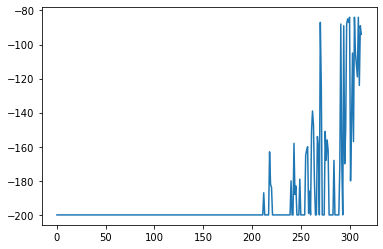

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -110:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()